# Reduction of synchronous Boolean networks with ERODE

ERODE enable reducing synchronous Boolean networks subject by grouping variables that, if initialized equally, are always updated equally. The resulting reduced state space is a subset of the original one, restricted to identical initialization of grouped variables. The corresponding trajectories of the original BN can be exactly restored.

See the papers [Reducing Boolean Networks with Backward Boolean Equivalence](https://doi.org/10.1007/978-3-030-85633-5_1) and [An Extension of ERODE to Reduce Boolean Networks By Backward Boolean Equivalence](https://doi.org/10.1007/978-3-031-15034-0_16) by Argyris et al.

The method can be applied to partially asynchronous dynamics by constraining the input partition of the reduction algorithm. This will appear soon to a journal extension of the previous article.

In [1]:
#!pip install erode-python # uncomment if outside Docker
import erode

## Basic usage

The `erode` Python models provides a `bbe_reduction` function which performs the reduction on a given Boolean network, specified either as a BoolNet file (`.bnet` extension), a `minibn.BooleanNetwork` object or any input supported by it, which includes `biolqm` or `ginsim` Python objects, and simple Python dictionnary objects.

Options `usermode` and `initial_partition` can be employed to control the reduction. By default, the maximal reduction is performed.

In [2]:
help(erode.bbe_reduction)

Help on function bbe_reduction in module erode:

bbe_reduction(model, output_bnet=None, usermode=None, initial_partition=None)
    Computes the Backward Boolean Equivalence reduction of the given Boolean networks
    specified by `model`.
    
    Returns a :py:class:`colomoto.minibn.BooleanNetwork` object of the reduced
    model, unless `output_bnet` is supplied. In this case, the reduced model is
    written to the filename `output_bnet`, and nothing is returned.
    
    :param model: Boolean network model
    :type model: filename in BoolNet format (`".bnet"`) or object of type
        :py:class:`colomoto.minibn.BooleanNetwork` or any type accepted by
        :py:class:`colomoto.minibn.BooleanNetwork` constructor
    :param str output_bnet: Filename for BoolNet export of the reduced model
    :param str usermode: predefined initial partition
        - `"INPUTS"`: every input  variable is isolated in a singleton block (plus one block for the other variables)
        - `"OUTPUTS"`: 

### Simple example using minibn

In [3]:
from colomoto import minibn

In [4]:
f = minibn.BooleanNetwork({
    "x1": "!x3 | x1",
    "x2": "x1 | x2 | !x3",
    "x3": "x2 & !x3"
})
f

x1 <- !x3|x1
x2 <- x1|x2|!x3
x3 <- x2&!x3

In [5]:
f_bbe = erode.bbe_reduction(f)
f_bbe

x1 <- !x3|x1
x3 <- x1&!x3

### Simple example using BoolNet files

In [6]:
%cat ap-1_else-0_wt.bnet

# model in BoolNet format
# the header targets, factors is mandatory to be importable in the R package BoolNet

targets, factors
Ap,    1
Ap2,   0
Dl,    !Ap&N
Dl2,   !Ap2&N2
Fng,   Ap
Fng2,  Ap2
N,     !Fng&Ser2 | Fng&Dl2
N2,    !Dl&Ser&!Fng2 | Dl&!Ser&Fng2 | Dl&Ser
Ser,   Ap
Ser2,  Ap2


In [7]:
erode.bbe_reduction("ap-1_else-0_wt.bnet", "ap-1_else-0_wt_BBE.bnet")
%cat ap-1_else-0_wt_BBE.bnet

# model in BoolNet format
# the header targets, factors is mandatory to be importable in the R package BoolNet

targets, factors
Ap, true
Ap2, false
Dl, (!Ap&N)
Dl2, (!Ap2&N2)
Fng, Ap
Fng2, Ap2
N, ((!Fng&Fng2) | (Fng&Dl2))
N2, ((((!Dl&Fng)&!Fng2) | ((Dl&!Fng)&Fng2)) | (Dl&Fng))


### Case study Ι

On a larger model imported from GINsim, we use BNS (https://people.kth.se/~dubrova/BNS/user_manual.html) using the [`bns` Python module](https://github.com/colomoto/bns-python/) for the computation of synchronous attractors in the original and reduced model.

In [8]:
import ginsim
import bns
import biolqm
from colomoto_jupyter import tabulate

In [9]:
tcr40_ginsim = ginsim.load("http://ginsim.org/sites/default/files/TCRsig40.zginml")
ginsim.show(tcr40_ginsim)

/notebook/tutorials/ERODE/TCRsig40.zginml

In [10]:
tcr40_red = erode.bbe_reduction(tcr40_ginsim)
len(tcr40_red)

29

In [11]:
tcr40_red

AP1 <- Fos&Jun
CD45 <- CD45
CRE <- CREB
CREB <- Fos
Ca <- DAG
Calcin <- Ca
DAG <- PLCg_a
ERK <- MEK
Fos <- ERK
Fyn <- ((CD45&!TCRbind)&LCK)|(CD45&TCRbind)
Gads <- LAT
IkB <- !Calcin
Itk <- ZAP70&Slp76
JNK <- Calcin
Jun <- JNK
LAT <- ZAP70
LCK <- (CD45&CD45)&!PAGCsk
MEK <- Raf
NFkB <- !IkB
PAGCsk <- !TCRbind
PLCg_a <- ((((!Rlk&ZAP70)&Itk)&Slp76)&Gads)|(((Rlk&ZAP70)&Slp76)&Gads)
Raf <- Ras
Ras <- Gads&RasGRP1
RasGRP1 <- DAG&Ca
Rlk <- LCK
Slp76 <- Gads
TCRbind <- CD45&!LAT
TCRphos <- ((!TCRbind&Fyn)|((TCRbind&!LCK)&Fyn))|(TCRbind&LCK)
ZAP70 <- (LCK&!LAT)&TCRphos

# computing graph layout...


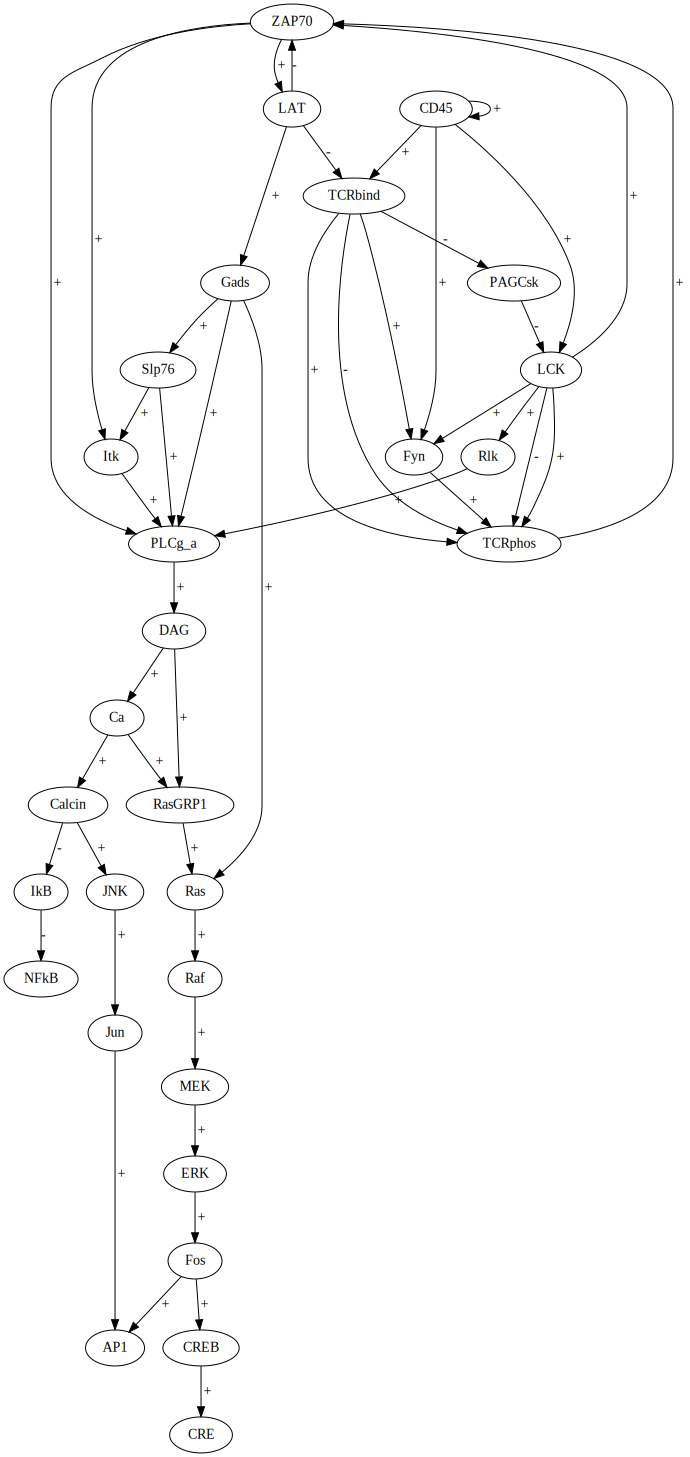

In [12]:
tcr40_red.influence_graph()

In [13]:
%time tabulate(bns.attractors(tcr40_red.to_biolqm()))

CPU times: user 398 ms, sys: 8.43 ms, total: 406 ms
Wall time: 454 ms


## Case study II : Cortical Area Development Network

This case study is the running example of the paper [Reducing Boolean Networks with Backward Boolean Equivalence](https://doi.org/10.1007/978-3-030-85633-5_1) .

In [14]:
CAD = minibn.BooleanNetwork.load("CAD.bnet")
len(CAD)

5

In [15]:
tabulate(bns.attractors(CAD.to_biolqm()))

,Coup_fti,Emx2,Fgf8,Pax6,Sp8
0,0,0,1,1,1
1,1,1,0,0,0


In [16]:
CAD_red = erode.bbe_reduction(CAD)
len(CAD_red)

4

In [17]:
tabulate(bns.attractors(CAD_red.to_biolqm()))

,Coup_fti,Emx2,Fgf8,Pax6
0,0,0,1,1
1,1,1,0,0


## Case Study III : Signalling macrophage activation

In [18]:
SMA = minibn.BooleanNetwork.load("SignallinginMacrophageActivation.bnet")
len(SMA)

321

Attractor detection of the original model takes a lot of time.

In [19]:
#tabulate(bns.attractors(SMA.to_biolqm()))

In [20]:
SMA_red = erode.bbe_reduction(SMA)
len(SMA_red)

8

In [21]:
%time tabulate(bns.attractors(SMA_red.to_biolqm()))

CPU times: user 12.7 ms, sys: 649 µs, total: 13.4 ms
Wall time: 26 ms


,S_1,S_10,S_101,S_105,S_153,S_177,S_251,S_85
0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,1,1,1


## Advanced usage

The `erode` module provides an API for interacting with ERODE partitions and reduction.

In [22]:
e = erode.load("ap-1_else-0_wt.bnet")
print(e)

ap-1_else-0_wt.bnet: 10 species.
Species:
[Ap, Ap2, Dl, Dl2, Fng, Fng2, N, N2, Ser, Ser2]
	Ap:	true
	Ap2:	false
	Dl:	(!Ap&N)
	Dl2:	(!Ap2&N2)
	Fng:	Ap
	Fng2:	Ap2
	N:	((!Fng&Ser2) | (Fng&Dl2))
	N2:	((((!Dl&Ser)&!Fng2) | ((Dl&!Ser)&Fng2)) | (Dl&Ser))
	Ser:	Ap
	Ser2:	Ap2


In [23]:
e.partition # current partition

{'Ap': 1,
 'Ap2': 1,
 'Dl': 1,
 'Dl2': 1,
 'Fng': 1,
 'Fng2': 1,
 'N': 1,
 'N2': 1,
 'Ser': 1,
 'Ser2': 1}

In [24]:
print(e.partition) # pretty print

The partition has 1 block out of 10 species:
Block 1, Size: 10
0-Ap 
1-Ap2 
2-Dl 
3-Dl2 
4-Fng 
5-Fng2 
6-N 
7-N2 
8-Ser 
9-Ser2 




In [25]:
bbe = e.bbe_partition()
print(bbe)

The partition has 8 blocks out of 10 species:
Block 1, Size: 1
0-Ap 

Block 2, Size: 1
1-Ap2 

Block 3, Size: 1
2-Dl 

Block 4, Size: 1
3-Dl2 

Block 5, Size: 2
4-Fng 
8-Ser 

Block 6, Size: 2
5-Fng2 
9-Ser2 

Block 7, Size: 1
6-N 

Block 8, Size: 1
7-N2 




In [26]:
f = e.reduce_model() # by default, returns a minibn.BooleanNetwork object
f

Ap <- 1
Ap2 <- 0
Dl <- !Ap&N
Dl2 <- !Ap2&N2
Fng <- Ap
Fng2 <- Ap2
N <- (!Fng&Fng2)|(Fng&Dl2)
N2 <- (((!Dl&Fng)&!Fng2)|((Dl&!Fng)&Fng2))|(Dl&Fng)

In [27]:
e.reduce_model(output_bnet="ap-1_else-0_wt_BBE.bnet") # silently outputs to file

The full java API is accessible through `e.japi`.